In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from functools import partial
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')

import sys
sys.path.append('../../')
from networks import get_time_step_embedding

In [6]:
time = jnp.linspace(0, 1, 50)
print(time.shape)
time_emb = jax.vmap(partial(get_time_step_embedding, embedding_dim=32, max_period=128.0, scaling=100.0))(time)
print(time_emb.shape)

(50,)
(50, 32)


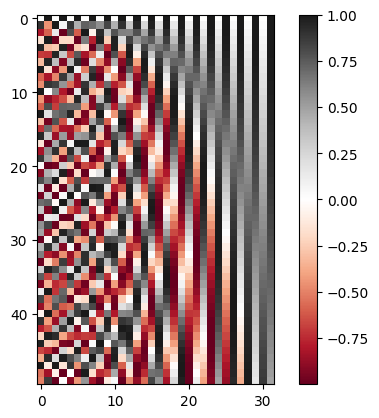

In [7]:
plt.imshow(time_emb.real, cmap='RdGy')
plt.colorbar()

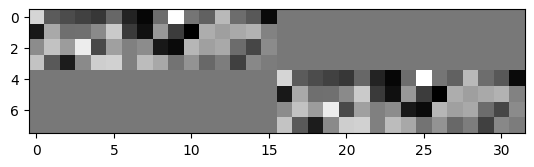

In [4]:
a = jax.random.normal(jax.random.PRNGKey(0), (4, 16))
zero_mat = jnp.zeros_like(a)
big_a = jnp.block([[a, zero_mat], [zero_mat, a]])
plt.figure()
plt.imshow(big_a, cmap='gray')

In [21]:
def complex_weighted_norm_square(x: jnp.ndarray, weight: jnp.ndarray) -> jax.Array:
    return jnp.einsum("...i,...ij,...j->...", jnp.conj(x), weight, x)

In [22]:
A = jnp.array(
    [1.0 + 2.0j, 1.0 + 3.0j]
)

B = jnp.array(
    [[2.0 + 1.0j, 3.0 + 3.0j],
     [1.0 + 1.0j, 2.0 + 1.0j]]
)

C = complex_weighted_norm_square(A, B)
print(C)

(56+45j)


In [23]:

# Create a complex-valued vector
v = jnp.array([1 + 2j, 3 + 4j, 5 + 6j])

# Create a complex-valued weight matrix
W = jnp.array([[2 + 1j, 1 - 1j, 0],
              [0, 3 + 2j, 1 + 2j],
              [1 - 1j, 2 + 1j, 4]])

# Compute v^H W v
inner_product = complex_weighted_norm_square(v, W)

print(inner_product)

(478+148j)


In [8]:
jnp.inner(A, A.conj())

Array(15.+0.j, dtype=complex64)

In [3]:
A_real, A_imag = jnp.real(A), jnp.imag(A)
B_real, B_imag = jnp.real(B), jnp.imag(B)

C_real = jnp.matmul(A_real, B_real) - jnp.matmul(A_imag, B_imag)
C_imag = jnp.matmul(A_real, B_imag) + jnp.matmul(A_imag, B_real)
C = C_real + 1.0j * C_imag

print("Seperating real and imaginary parts: \n", C)

Seperating real and imaginary parts: 
 [[-2. +9.j -4.+16.j]
 [ 5. +8.j  8.+14.j]]


In [47]:
from sdebridge.data_processing import butterfly_amasina_pts
from sdebridge.sde import SDE
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.solver import euler_maruyama
from matplotlib import colormaps

from ml_collections import ConfigDict

In [75]:
def sample_ellipse(
    n_samples: int,
    scale: float = 1.0,
    shifts: jnp.ndarray = jnp.array([0.0, 0.0]),
    a: float = 1.0,
    b: float = 1.0,
) -> jnp.ndarray:
    theta = jnp.linspace(0, 2 * jnp.pi, n_samples, endpoint=False)
    x = a * jnp.cos(theta)
    y = b * jnp.sin(theta)
    return scale * jnp.stack([x, y], axis=1) + shifts[None, :]

In [122]:
# S0 = jnp.array(butterfly_amasina_pts())[:, ::238][:, 1:].transpose()
S0 = sample_ellipse(64)

In [123]:
n_bases = 4
n_samples = S0.shape[0]

ks_truncated = jnp.fft.fftfreq(n_bases, d=1.0/(2.0*jnp.pi))  # (n_bases, )
kks_truncated = jnp.stack(jnp.meshgrid(ks_truncated, ks_truncated, indexing='ij'), axis=-1)

In [124]:
fourier_base_func_1d = lambda m, k: jnp.exp(1j * m * k)

def evalute_S_on_bases(S: jnp.ndarray, ks: jnp.ndarray) -> jnp.ndarray:
    n_samples = S.shape[0]
    S_fft = jax.vmap(partial(jnp.fft.fft, norm="ortho"), in_axes=1, out_axes=1)(S) # (n_samples, 2)
    S_fft_shifted = jnp.fft.fftshift(S_fft, axes=0) # (n_samples, 2)
    base = lambda k: jnp.exp(1j * jnp.arange(-n_samples//2, n_samples//2) * k) # (n_samples, )
    bases = jax.vmap(base)(ks) # (n_bases, n_samples)
    S_eval = jnp.matmul(bases, S_fft_shifted) / jnp.sqrt(n_samples) # (n_bases, 2)
    return S_eval

def evaluate_X_on_bases(X_coeffs: jnp.ndarray, n: int) -> jnp.ndarray:
    X_eval = jax.vmap(partial(jnp.fft.irfft, norm="forward", n=n), in_axes=1, out_axes=1)(X_coeffs / jnp.sqrt(n_samples))
    return X_eval

def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def evaluate_Q_on_bases(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    kernel_func = partial(gaussian_kernel_2d, sigma=sigma, alpha=alpha)
    St_eval = evaluate_X_on_bases(X_coeffs, n=n_bases) + S0_eval   # (n_bases, 2)
    Q_eval = jax.vmap(
        jax.vmap(
            jax.vmap(kernel_func, 
                 (None, 0), 
                 0), 
            (None, 1), 
            1), 
        (0, None), 
        0)(St_eval, kks_truncated)
    return Q_eval

def evaluate_Q_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_eval = evaluate_Q_on_bases(X_coeffs, S0_eval, sigma, alpha) # (n_bases, n_bases, n_bases)
    Q_coeffs = jax.vmap(partial(jnp.fft.fft2, norm="forward"))(Q_eval)    # (n_bases, n_bases, n_bases)
    Q_coeffs_shifted = jnp.fft.fftshift(Q_coeffs, axes=(-2, -1))
    Q_coeffs_shifted = Q_coeffs_shifted.reshape(n_bases, -1)    # (n_bases, n_bases ** 2)
    return Q_coeffs_shifted

def evaluate_diffusion_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_coeffs_shifted = evaluate_Q_coeffs(X_coeffs, S0_eval, sigma, alpha) # (n_bases, n_bases ** 2)
    fs = jax.vmap(fourier_base_func_1d, (0, None))(jnp.arange(n_bases), ks_truncated)
    return jnp.matmul(fs, Q_coeffs_shifted)    # (n_bases, n_bases**2)

S0_eval shape:  (4, 2)


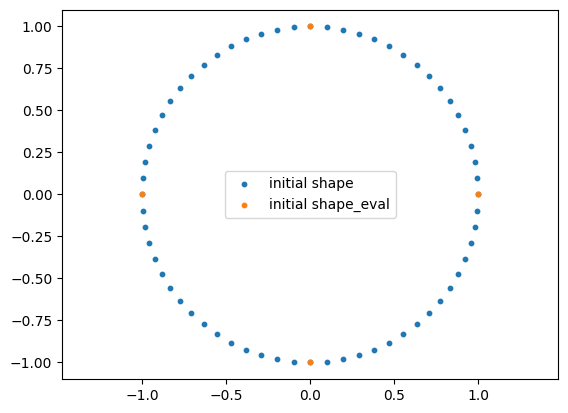

In [125]:
S0_eval = evalute_S_on_bases(S0, ks_truncated)
print("S0_eval shape: ", S0_eval.shape)

plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0], S0_eval[:, 1], s=10, label='initial shape_eval')
plt.axis('equal')
plt.legend()

In [126]:
class GaussianKernelFuncBasisSDE(SDE):
    def __init__(self, config):
        self.config = config

    def drift(self, val, time) -> jnp.ndarray:
        return jnp.zeros_like(val)
    
    def diffusion(self, val, time) -> jnp.ndarray:
        val = jnp.stack(jnp.split(val, 2, axis=-1), axis=-1)
        Q_mat = evaluate_diffusion_coeffs(val, self.config.S0_eval, self.config.sigma, self.config.alpha)
        zero_mat = jnp.zeros_like(Q_mat)
        Q = jnp.block([[Q_mat, zero_mat], [zero_mat, Q_mat]])
        return Q

In [130]:
sde_config = ConfigDict(
    {
        'S0_eval': S0_eval,
        'T': 1.0,
        'N': 100,
        'dim': 2,
        'n_bases': n_bases,
        'sigma': 0.2,
        'alpha': 1.0,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)
bridge = DiffusionBridge(sde)

In [131]:
X0 = jnp.zeros((2*n_bases, ), dtype=jnp.complex64)
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 100, 8)
Xs_recon shape:  (1, 100, 64, 2)
Ss shape:  (1, 100, 64, 2)


(-1.1009787738323211,
 1.104406875371933,
 -1.1005071699619293,
 1.102845698595047)

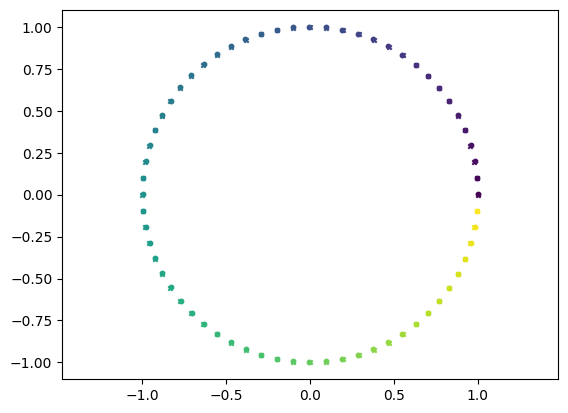

In [132]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_coeffs = jnp.stack(jnp.split(Xs_coeffs, 2, axis=-1), axis=-1)
Xs_recon = jax.vmap(jax.vmap(partial(evaluate_X_on_bases, n=S0.shape[0])))(Xs_coeffs)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon.real
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(jnp.linspace(0, 1,  S0.shape[0]))
for i in range(S0.shape[0]):
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=10, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.5)
plt.axis('equal')